<a href="https://colab.research.google.com/github/tbottelbergs/cv_copy/blob/master/CV_V0.0.6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision Final project

# Version History

## V0.0.1 
* One-hot encoding (based on first class)
* Predictions based on softmax (no extra hidden layer of MobileNetV2)
* Optimizer='rmsprop', Loss='categorical_crossentropy'

## V0.0.2
* Added extra hidden layer of 1024 nodes
* Accuracy never rises above 74% (depends on which class is selected as first class)

## V0.0.3
* Added multi-label targets
* Changed output layer to 'sigmoid' activation function
* Changed the loss function to tf.keras.losses.CategoricalCrossentropy(from_logits=True)
* Changed the metric to categorical_accuracy

## V0.0.4
* Changed loss function to tf.nn.sigmoid_cross_entropy_with_logits
-> doesn't make things better

## V0.0.5
* Using TruePositives, TrueNegatives, FalsePositives, FalseNegatives, TopKCategoricalAccuracy(k=1) as metric
* Added fine tuning of last 55 layers of the base model

## V0.0.6
* Split training and test as was done for the VOC dataset
* Removed from_logits = True
* Switched to BinaryCrossentropy instead of CategoricalCrossentropy
* Used Adam optimiser

## V0.0.7
* Using TopKCategoricalAccuracy with k=2

Fetch data

In [0]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
import random
import tensorflow as tf
from xml.dom import minidom
import matplotlib.pyplot as plt

In [42]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals



File ‘VOCtrainval_11-May-2009.tar’ already there; not retrieving.

Total bytes read: 935536640 (893MiB, 290MiB/s)


To keep in mind:
* In one image, multiple objects can appear (also of different classes)
* Every image has at least one object in it?

In [0]:
voc_root_folder = "/content/VOCdevkit/VOC2009"
trainImageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','train.txt')
valImageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','val.txt')
trainImageNames = np.loadtxt(trainImageNamesFile, dtype='str')
valImageNames = np.loadtxt(valImageNamesFile, dtype='str')

In [44]:
CLASSES = ['aeroplane','bicycle','bird','boat','bottle', 'bus','car','cat','chair','cow', 'diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
class_to_idx = dict((c, i) for i, c in enumerate(CLASSES))
idx_to_class = dict((i, c) for i, c in enumerate(CLASSES))
def one_hot_encode(clss):
  encoded = [0 for _ in range(len(CLASSES))]
  for cls in clss:
    encoded[class_to_idx[cls]] = 1
  return encoded
def one_hot_decode(encoded):
  clss = [idx_to_class[idx] for idx, val in enumerate(encoded) if val == 1]
  return clss
a = one_hot_encode(['bicycle', 'bus', 'chair'])
print(a)
print(one_hot_decode(a))

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['bicycle', 'bus', 'chair']


In [0]:
image_folder = os.path.join(voc_root_folder, "JPEGImages")
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def createDataSet(imageNames):
  images = []
  targets = []
  for imageName in imageNames:
    xmlFile = os.path.join(voc_root_folder,'Annotations',imageName + '.xml')
    xml = minidom.parse(xmlFile)
    objectsXml = xml.getElementsByTagName('object')
    objects = []
    image = resize(io.imread(os.path.join(image_folder,imageName + ".jpg")), IMG_SHAPE)
    for objectXml in objectsXml:
      object = objectXml.getElementsByTagName('name')[0].firstChild.nodeValue
      if object not in objects:
        objects.append(object)
    #if(len(objects) == 1):
    targets.append(one_hot_encode(objects))
    images.append(image)
  return (images,targets)

In [0]:
trainImages, trainTargets = createDataSet(trainImageNames)
validationImages, validationTargets = createDataSet(valImageNames)

In [47]:
print(len(trainImages))
print(trainTargets)

3473
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0

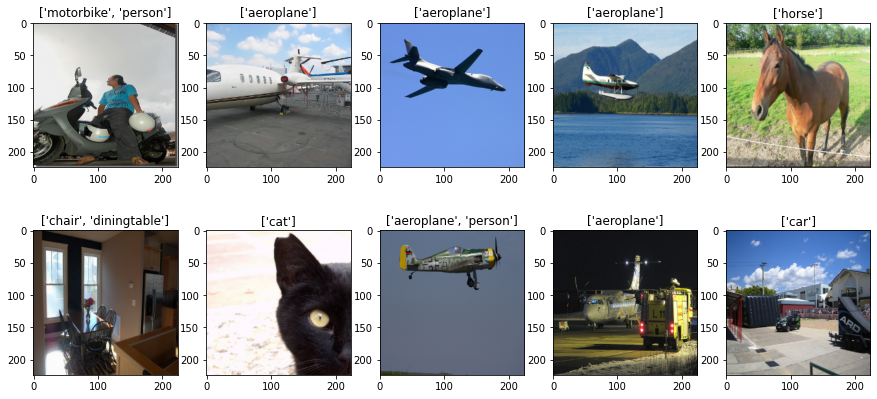

In [48]:
fig=plt.figure(figsize=(15, 7))
for i in range(1,6):
  idx = random.randint(0,len(trainImages))
  fig.add_subplot(2, 5, i)
  plt.imshow(trainImages[idx])
  plt.title(one_hot_decode(trainTargets[idx]))
for i in range(6,11):
  idx = random.randint(0,len(validationImages))
  fig.add_subplot(2, 5, i)
  plt.imshow(validationImages[idx])
  plt.title(one_hot_decode(validationTargets[idx]))

In [0]:
x_train = np.array(trainImages).astype('float32')
y_train = np.array(trainTargets)
x_val = np.array(validationImages).astype('float32')
y_val = np.array(validationTargets)

In [0]:
BATCH_SIZE = 100
train_batches = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
validation_batches = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [0]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [0]:
base_model.trainable = False

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = tf.keras.layers.Dense(20, activation='sigmoid')
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
  predictions
])
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Sum(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [54]:
print(len(base_model.layers))

155


In [55]:
print(sum(sum(y_train)))
print(y_train.shape)

5328
(3473, 20)


In [56]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
35/35 [==============================] - 124s 4s/step - loss: 0.1880 - sum: 2536.7495 - true_positives_2: 2522.0000 - true_negatives_2: 62752.0000 - false_positives_2: 1380.0000 - false_negatives_2: 2806.0000 - top_k_categorical_accuracy: 0.5154 - val_loss: 0.1132 - val_sum: 3416.0850 - val_true_positives_2: 3527.0000 - val_true_negatives_2: 65308.0000 - val_false_positives_2: 928.0000 - val_false_negatives_2: 1857.0000 - val_top_k_categorical_accuracy: 0.6621
Epoch 2/10
35/35 [==============================] - 123s 4s/step - loss: 0.0935 - sum: 3646.2822 - true_positives_2: 3762.0000 - true_negatives_2: 63506.0000 - false_positives_2: 626.0000 - false_negatives_2: 1566.0000 - top_k_categorical_accuracy: 0.6879 - val_loss: 0.1039 - val_sum: 3574.3635 - val_true_positives_2: 3660.0000 - val_true_negatives_2: 65468.0000 - val_false_positives_2: 768.0000 - val_false_negatives_2: 1724.0000 - val_top_k_categorical_accuracy: 0.6694
Epoch 3/10
35/35 [==============================]

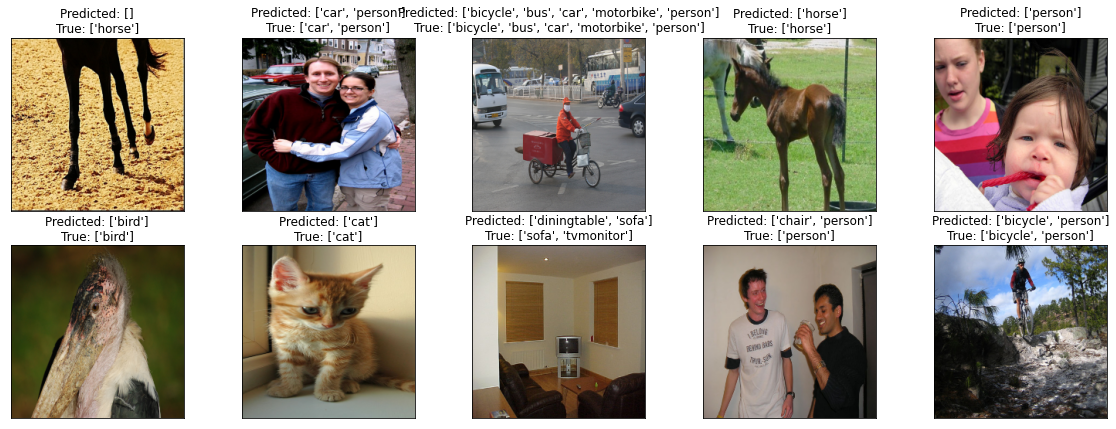

In [57]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow(x_train[idx])
  y_pred = one_hot_decode(np.around(model(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow(x_val[idx])
  y_pred = one_hot_decode(np.around(model(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

In [0]:
base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Sum(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [60]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
35/35 [==============================] - 173s 5s/step - loss: 0.1057 - sum: 3597.8660 - true_positives_3: 3626.0000 - true_negatives_3: 63282.0000 - false_positives_3: 850.0000 - false_negatives_3: 1702.0000 - top_k_categorical_accuracy: 0.6300 - val_loss: 2.3091 - val_sum: 1831.7036 - val_true_positives_3: 1810.0000 - val_true_negatives_3: 64095.0000 - val_false_positives_3: 2141.0000 - val_false_negatives_3: 3574.0000 - val_top_k_categorical_accuracy: 0.1667
Epoch 2/10
35/35 [==============================] - 171s 5s/step - loss: 0.0587 - sum: 4255.9185 - true_positives_3: 4368.0000 - true_negatives_3: 63617.0000 - false_positives_3: 515.0000 - false_negatives_3: 960.0000 - top_k_categorical_accuracy: 0.7161 - val_loss: 1.3471 - val_sum: 2506.7034 - val_true_positives_3: 2503.0000 - val_true_negatives_3: 63337.0000 - val_false_positives_3: 2899.0000 - val_false_negatives_3: 2881.0000 - val_top_k_categorical_accuracy: 0.2094
Epoch 3/10
35/35 [==============================]

* categorical_accuracy: the node with the highest output should also be a detected label
* sigmoid_cross_entropy_with_logits

In [61]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [62]:
m = tf.keras.metrics.CategoricalAccuracy() 
_ = m.update_state([[0,0,1,0],[0, 1, 0, 0]], [[0,0.1,0.1,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [63]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
_ = m.update_state([[0,0,1,1],[0, 1, 0, 0]], [[0,0.6,0.5,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [64]:
print(x_val[0:1].shape)

(1, 224, 224, 3)


In [65]:
y_pred = model(x_val[0:1])
y_pred = np.around(y_pred).astype('int')
print(y_pred)
print(one_hot_decode(y_pred[0]))
print(one_hot_decode(y_val[0]))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]
['person']
['tvmonitor']


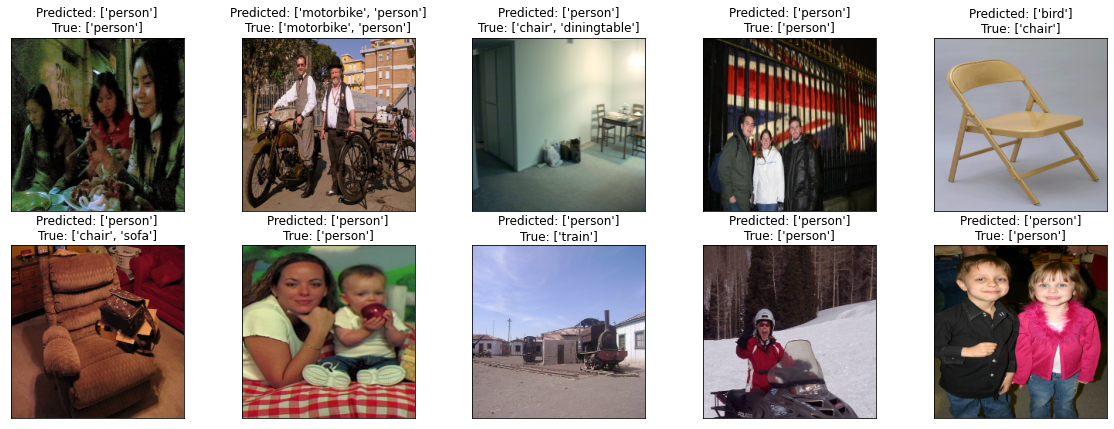

In [66]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow(x_train[idx])
  y_pred = one_hot_decode(np.around(model(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow(x_val[idx])
  y_pred = one_hot_decode(np.around(model(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])